> <p><small><small>This Notebook is made available subject to the licence and terms set out in the <a href = "http://www.github.com/google-deepmind/ai-foundations">AI Research Foundations Github README file</a>.

<img src="https://storage.googleapis.com/dm-educational/assets/ai_foundations/GDM-Labs-banner-image-C3-white-bg.png">

# Lab: Make Predictions with a Single-Layer Neural Network

<a href='https://colab.research.google.com/github/google-deepmind/ai-foundations/blob/master/course_3/gdm_lab_3_2_make_predictions_with_a_single_layer_neural_network.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

Separate embeddings into two classes with a single-layer neural network.

15 minutes

## Overview

In this lab, you will gain an intuitive understanding of how neural networks and multi-layer perceptrons work by investigating how a single artificial neuron makes decisions. You will see how a separating line can classify two classes of 2D data points. In the dataset provided, each datapoint corresponds to the embedding of a prompt. The classifier's task is to predict the next token from the two tokens "water" and "food".





### What you will learn:

By the end of this lab, you will:
* Understand how data can be separated for performing binary classification.


### Tasks

Your task is to adjust the weights and bias of a single artificial neuron to find a decision boundary that separates the two classes. This neuron uses a sigmoid activation function to compute the probability of class 1. This type of classifier is also known as a logistic regression classifier, which you may have previously encountered if you have ever taken a statistics course.

**In this lab, you will**:
* Load the dataset of 2-dimensional embeddings.
* Visualize the dataset.
* Manually adjust the weights and the bias term until the result decision boundary perfectly separates the two classes.

All of these steps are described in detail in the following sections.

## How to use Google Colaboratory (Colab)

Google Colaboratory (also known as Google Colab) is a platform that allows you to run Python code in your browser. The code is written in *cells* that are executed on a remote server.

To run a cell, hover over a cell and click on the `run` button to its left. The run button is the circle with the triangle (▶). Alternatively, you can also click on a cell and use the keyboard combination Ctrl+Return (or ⌘+Return if you are using a Mac).

To try this out, run the following cell. This should print today's day of the week below it.

In [ ]:
from datetime import datetime

print(f"Today is {datetime.today():%A}.")

Note that the order in which you run the cells matters. When you are working through a lab, make sure to always run all cells in order. Otherwise, the code might not work. If you take a break while working on a lab, Colab may disconnect you. In that case, you have to execute all cells again before continuing your work. To make this easier, you can select the cell you are currently working on and then choose __Runtime → Run before__  from the menu above (or use the keyboard combination Ctrl/⌘ + F8). This will re-execute all cells before the current one.

## Imports

In this lab, you will use the `numpy` module of the `JAX` package for defining vectors. This package implements almost the same functions as the `numpy` module which you have encountered in the previous course. However, this has been optimized for defining data and parameters for neural networks. As you will see in later modules of this course, it also comes with additional functionality that makes it easier to train neural networks. For now, think of it exactly the same way as `numpy` but instead of prefixing everything with `np`, prefix everything with `jnp` (for `jax.numpy`). This lab also uses `pandas` for loading and displaying the dataset and the custom `ai_foundations` package for creating plots.

Run the following cell to import all required packages.

In [1]:
%%capture
# Install the custom package for this course.
!pip install "git+https://github.com/google-deepmind/ai-foundations.git@main"

# Packages used.
import jax.numpy as jnp # For defining vectors and matrices.
import pandas as pd # For loading and displaying the dataset.
from ai_foundations import visualizations # For creating plots.


## Load dataset

You will work with a small dataset which contains the embeddings for predicting the next token for 20 different prompts. These **prompt embeddings** work similarly as the token embeddings that you have seen in the previous course. However, the idea behind prompt embeddings is that they encode not only the information of an individual token, but also the information of an entire prompt. You will learn in the next course (04 Discover the Transformer Architecture), how you can use transformer models to compute such prompt embeddings. For now, assume that there are methods to obtain such prompt embeddings and that the output of this method are the 2D datapoints in the dataset that you are loading.

In this dataset, for half of the prompt embeddings, the likely next token is "food", and for the other half the likely next token is "water". The goal of the classifier you are building in this lab is to correctly predict the next token.

Run the following cell to download the data.

In [2]:
# Load data using pandas.
df = pd.read_csv("https://storage.googleapis.com/dm-educational/assets/ai_foundations/food-water-dataset.csv")

# Extract embeddings (Embedding_dim_1, Embedding_dim_2) and labels.
# These are represented as a JAX array using the jnp.array function.
input_features = jnp.array(df[["Embedding_dim_1", "Embedding_dim_2"]].values)
labels = df["Label"].values # Labels: "food" or "water".

# Convert labels to numeric values for plotting (food = 1, water = 0).
numeric_labels = jnp.where(labels == "food", 1, 0)

# Print the loaded data for verification.
df.head(n=20)

,Prompt,Embedding_dim_1,Embedding_dim_2,Label
0,Jide was hungry so she went looking for,0.27,0.39,food
1,The best part of the street fair was the incre...,1.06,0.89,food
2,He opened the refrigerator and it was full of ...,0.77,0.65,food
3,The main attraction at the festival was the am...,0.66,1.09,food
4,The lion went hunting for,0.61,1.64,food
5,The farmers worked hard to grow a lot of,0.94,1.29,food
6,Her favourite part of visiting new places is t...,0.61,0.78,food
7,The toddlers made a huge mess with their,0.89,1.13,food
8,The market sells a lot of delicious fresh,0.64,0.98,food
9,My doctor advised me to avoid very fatty,0.71,0.41,food


### Plot the data points

As a first step, run the following cell to plot the two-dimensional embeddings.

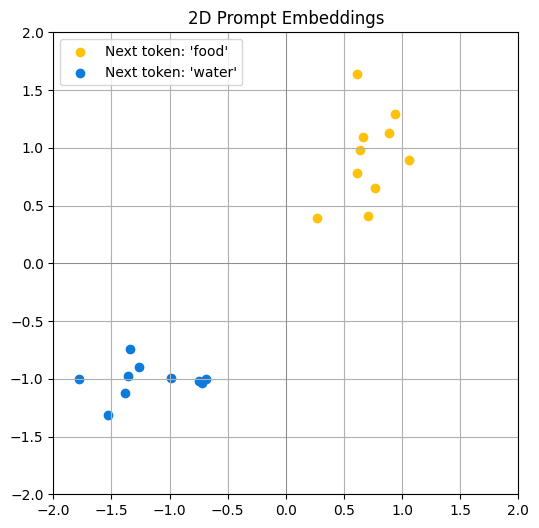

In [3]:
visualizations.plot_data_and_decision_boundary(
    input_features, labels, title="2D Prompt Embeddings"
)

The blue dots correspond to prompt embeddings for which the next token should be "water" and the yellow dots correspond to prompt embeddings for which the next token should be "food". All of the blue dots are quite close together and the same is true for all of the yellow dots. This enables you to build a classifier that can separate the classes with high accuracy. This allows you to build a language model that can adequately predict the next token from this list of two possible tokens.

Also note that all of these data points are treated as training examples, so currently there is no separate **test set**. In later labs, you will automatically train models and for those labs, you will first split the dataset into a training and test set.



## Coding Activity 1: Tune the weight and bias manually

Recall from the previous article that a single layer of a multi-layer perceptron (MLP) computes a weighted sum of the input vector $\mathbf{x}$ by computing the dot product between $\mathbf{x}$ and the weight vector $\mathbf{w}$. The final output $y$ is then computed by adding the bias term $b$ and applying a non-linear activation function, such as the sigmoid function $\sigma$:

$$ y = \sigma(\mathbf{w} \cdot \mathbf{x} + b).$$

In this activity, you will manually adjust the weight vector $\mathbf{w}$ and the bias term $b$, such that the resulting classifier perfectly separates the two classes in your dataset.

Remember that the sigmoid function returns a value greater than 0.5 for positive values and a value smaller than 0.5 for negative values. Therefore, your classifier will work correctly if $\mathbf{w} \cdot \mathbf{x} + b > 0$ for all data points of the positive class (here arbitrarily chosen to be "food") and $\mathbf{w} \cdot \mathbf{x} + b < 0$ for all data points of the negative class (here arbitrarily chosen to be "water").

One useful visualization of a classifier with 2D inputs are plots that show the **decision boundary**. This is a line (or multiple lines) that separate the 2D space such that on one side of the boundary the classifier predicts one class for all points, and on the other side of the boundary, the classifier predicts the other class for all points.

<br/>

------
> **💻 Your task:**
>
>In the cell below, adjust the values of the weight vector $\mathbf{w}$ and the bias term $b$. Keep adjusting them until you find a decision boundary that separates the two classes.
>
> Consider the folllowing:
>* Choose a weight vector that is close to the prompt embeddings of the positive class (i.e., the points of the class "food"). This will result in a weight vector that has high similarity to the points of the "food" class. Remember from the previous course that two vectors with high similarity, have a positive dot product. So if you point the weight vector towards examples of the positive class, you are making it similar to examples of that class.
>* Investigate what happens when the dot product between the weight vector and a data point is zero (or close to 0), that is, when $\mathbf{w} \cdot \mathbf{x} + b \approx 0$. Data points for which this is true are called **orthogonal points**.
------

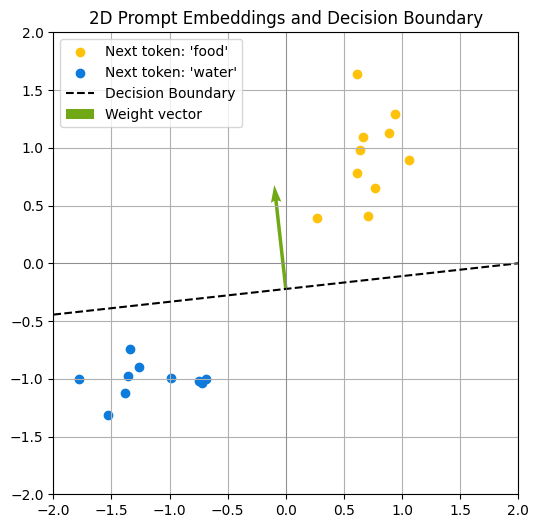

Classification errors:
food: 0
water: 0


✅ Well done! Your decision boundary correctly separates all data points.


In [5]:
# Initial guess for weights and bias.
weight_vector = jnp.array([-0.1, 0.9])  # Weight vector: [w1, w2].
bias_term = 0.2  # Bias term.

visualizations.plot_data_and_decision_boundary(
    input_features, labels, weight_vector, bias_term, provide_feedback=True
)


### What did you observe?

Note that the points of the positive class ("food") are all concentrated around $(1,1)$. Consequently, if you choose a weight vector that is similar to $(1,1)$, this vector will point in the direction of the positive class. This means that $\mathbf{w} \cdot \mathbf{x} + b > 0$ for all points of the positive class, and $\mathbf{w} \cdot \mathbf{x} + b < 0$ for all points of the negative class ("water").

By setting the bias term to a value close to $0$, you further avoid orthogonal points, that is, points for which the dot product is $0$ or close to $0$. A decision boundary such as this is ideal, as it is as far away as possible from all points while perfectly separating the data.

## Summary
In this lab, you explored how to separate two classes of token embeddings in 2D space using a single artificial neuron. You investigated how to reposition the decision boundary to separate the classes properly by adjusting the weight vector and bias. Through manual tuning, you gained an understanding of how dot products relate to classification.

You observed that, to separate the classes well, the weight vector needs to be pointed in the direction of the "positive" class ("food" in this case). Additionally, you observed that when a data point lies exactly on the boundary, its dot product with the weight vector is zero. This means that the point is orthogonal to the boundary, indicating that the point is not classified into any class.

## Solutions

The following cells provide reference solutions to the coding activities in this notebook. If you really get stuck after trying to solve the activities yourself, you may want to consult these solutions.

It is recommended that you *only* look at the solutions after you have tried to solve the activities *multiple times*. The best way to learn challenging concepts in computer science and artificial intelligence is to debug your code piece-by-piece until it works, rather than copying existing solutions.

If you feel stuck, you may want to first try to debug your code. For example, by adding additional print statements to see what your code is doing at every step. This will provide you with a much deeper understanding of the code and the materials. It will also provide you with practice on how to solve challenging coding problems beyond this course.

To view the solutions for an activity, click on the arrow to the left of the activity name. If you consult the solutions, do not copy and paste them into the cells above. Instead, look at them, and type them manually into the cell. This will help you understand where you went wrong.

### Coding Activity 1

In [ ]:
# One setting that perfectly separates the data.
weight_vector = jnp.array([1.0, 1.0])
bias_term = 0  # Bias term.
